In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from scipy import stats

In [12]:
df = pd.read_csv('../data/student_habits_performance.csv')

In [13]:
df.isna().sum()

student_id                        0
age                               0
gender                            0
study_hours_per_day               0
social_media_hours                0
netflix_hours                     0
part_time_job                     0
attendance_percentage             0
sleep_hours                       0
diet_quality                      0
exercise_frequency                0
parental_education_level         91
internet_quality                  0
mental_health_rating              0
extracurricular_participation     0
exam_score                        0
dtype: int64

In [14]:
df['parental_education_level'] = df['parental_education_level'].fillna(df['parental_education_level'].mode()[0])

In [15]:
numerical_cols = df.select_dtypes(include='number')

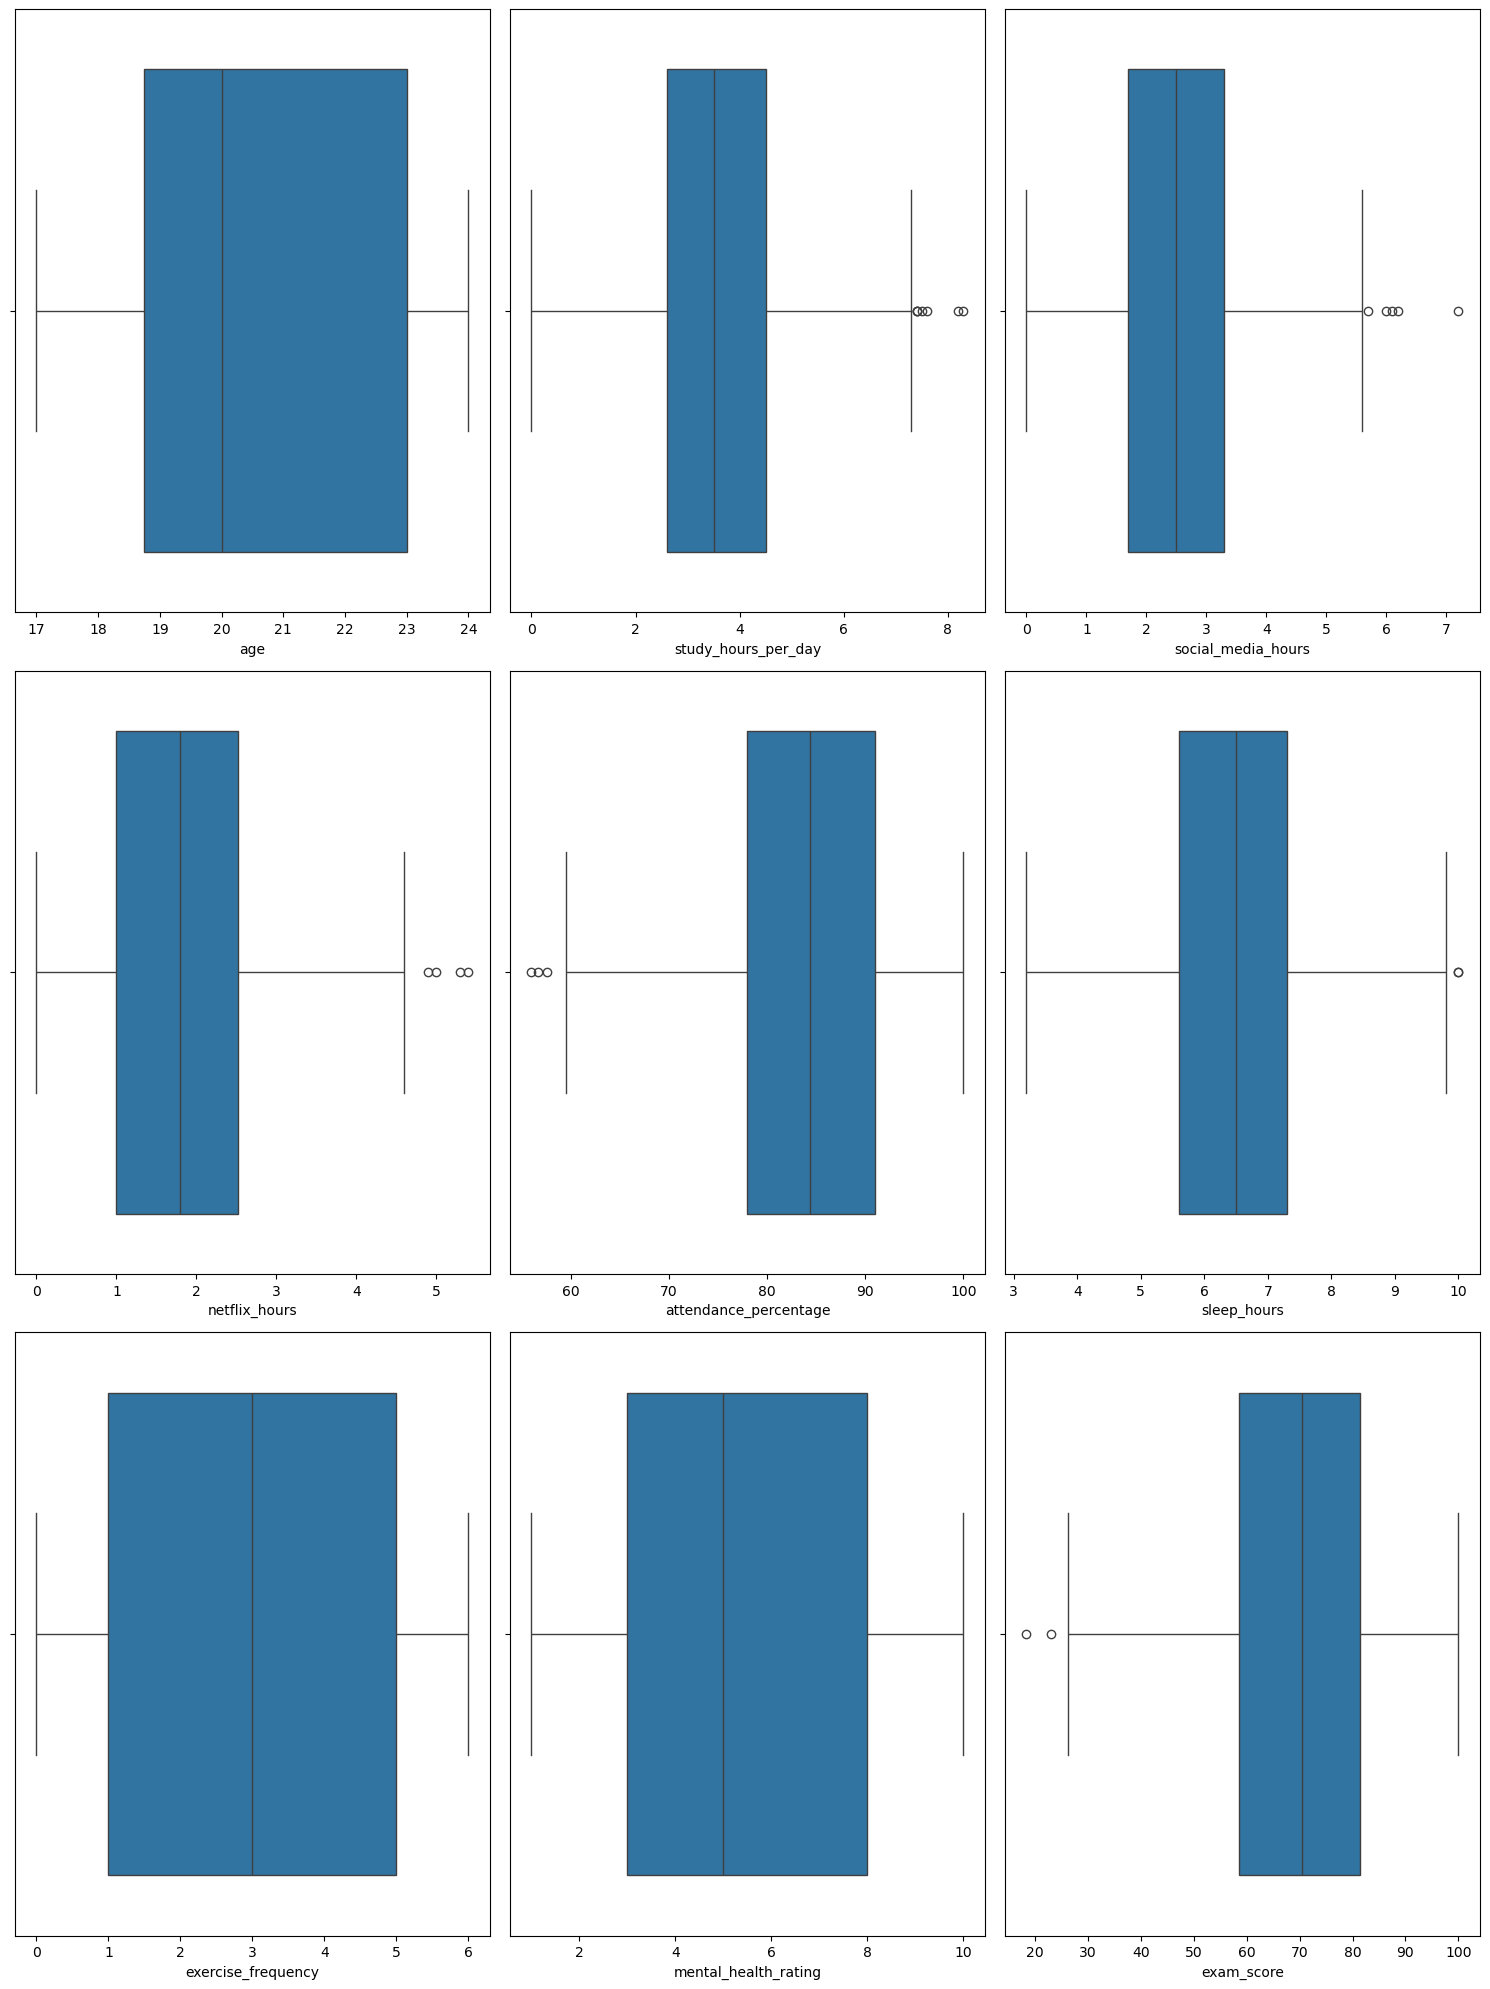

In [20]:
f,axes = plt.subplots(3,3,figsize=(15, 20))

axes = axes.flatten()

for i, feature in enumerate(numerical_cols.columns):
    sns.boxplot(x=df[feature], ax=axes[i])

plt.tight_layout()
plt.savefig('../doc/img/boxplot1.png')
plt.show()

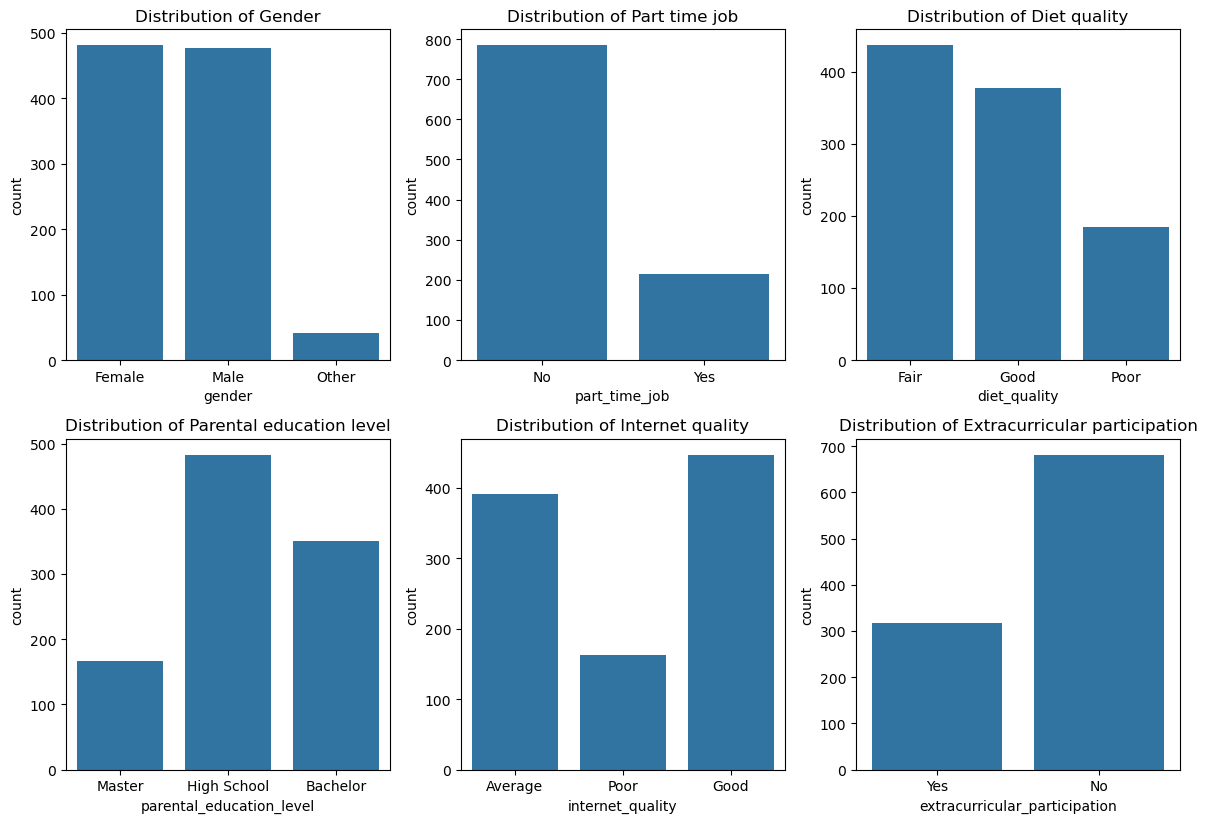

In [21]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

n = len(categorical_cols)
cols = 3 
rows = (n + cols - 1) // cols

plt.figure(figsize=(12,12))

for i, col in enumerate(categorical_cols[1:], 1):
    plt.subplot(rows, cols, i)
    sns.countplot(x=col, data=df)
    plt.title(f'Distribution of {col.capitalize().replace("_", " ")}')

plt.tight_layout()
plt.savefig('../doc/img/histogram1.png')
plt.show()

In [23]:
df_processed = df.copy()
for col in numerical_cols.columns:
    Q1 = df_processed[col].quantile(0.25)
    Q3 = df_processed[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_processed = df_processed[(df_processed[col] >= lower_bound) & (df_processed[col] <= upper_bound)]

In [29]:
df_processed = df.copy()
original_rows = len(df_processed)

# Dicionário para armazenar informações sobre as alterações
outliers_report = {
    'variable': [],
    'original_rows': [],
    'remaining_rows': [],
    'rows_removed': [],
    'percentage_removed': []
}

for col in numerical_cols.columns:
    # Armazena contagem original de linhas para esta coluna
    original_col_rows = len(df_processed)
    
    # Cálculo dos quartis e limites
    Q1 = df_processed[col].quantile(0.25)
    Q3 = df_processed[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filtragem
    mask = (df_processed[col] >= lower_bound) & (df_processed[col] <= upper_bound)
    df_processed = df_processed[mask]
    
    # Calcula estatísticas de remoção
    remaining_rows = len(df_processed)
    rows_removed = original_col_rows - remaining_rows
    pct_removed = (rows_removed / original_col_rows) * 100
    
    # Adiciona ao relatório
    outliers_report['variable'].append(col)
    outliers_report['original_rows'].append(original_col_rows)
    outliers_report['remaining_rows'].append(remaining_rows)
    outliers_report['rows_removed'].append(rows_removed)
    outliers_report['percentage_removed'].append(round(pct_removed, 2))

# Cria dataframe com o relatório
outliers_df = pd.DataFrame(outliers_report)

# Mostra apenas variáveis que tiveram outliers removidos
outliers_affected = outliers_df[outliers_df['rows_removed'] > 0]

In [33]:
def generate_outliers_markdown(outliers_affected):
    """
    Gera markdown formatado com a tabela de outliers removidos
    
    Args:
        outliers_affected (pd.DataFrame): DataFrame com as informações de outliers removidos
    
    Returns:
        str: String formatada em markdown
    """
    if len(outliers_affected) == 0:
        return "**Nenhum outlier foi removido das variáveis numéricas.**"
    
    # Cria o cabeçalho da tabela
    markdown = "| Variável | Linhas Originais | Linhas Restantes | Linhas Removidas | % Removida |\n"
    markdown += "|----------|------------------|------------------|------------------|------------|\n"
    
    # Adiciona cada linha do DataFrame
    for _, row in outliers_affected.iterrows():
        markdown += f"| {row['variable']} | {row['original_rows']} | {row['remaining_rows']} | "
        markdown += f"{row['rows_removed']} | {row['percentage_removed']}% |\n"
    
    # Calcula totais
    total_removed = outliers_affected['rows_removed'].sum()
    original_total = outliers_affected['original_rows'].iloc[0]  # Pega o primeiro valor (todos iguais)
    pct_total = (total_removed / original_total) * 100
    
    # Adiciona resumo
    markdown += f"\n**Total de linhas removidas do dataset:** {total_removed} ({pct_total:.2f}%)\n"
    
    return markdown

# Gera o markdown
outliers_markdown = generate_outliers_markdown(outliers_affected)

# Salva em um arquivo .md
with open('outliers_report.md', 'w', encoding='utf-8') as f:
    f.write("# Relatório de Remoção de Outliers\n\n")
    f.write(outliers_markdown)
    
print("Arquivo 'outliers_report.md' gerado com sucesso!")

Arquivo 'outliers_report.md' gerado com sucesso!


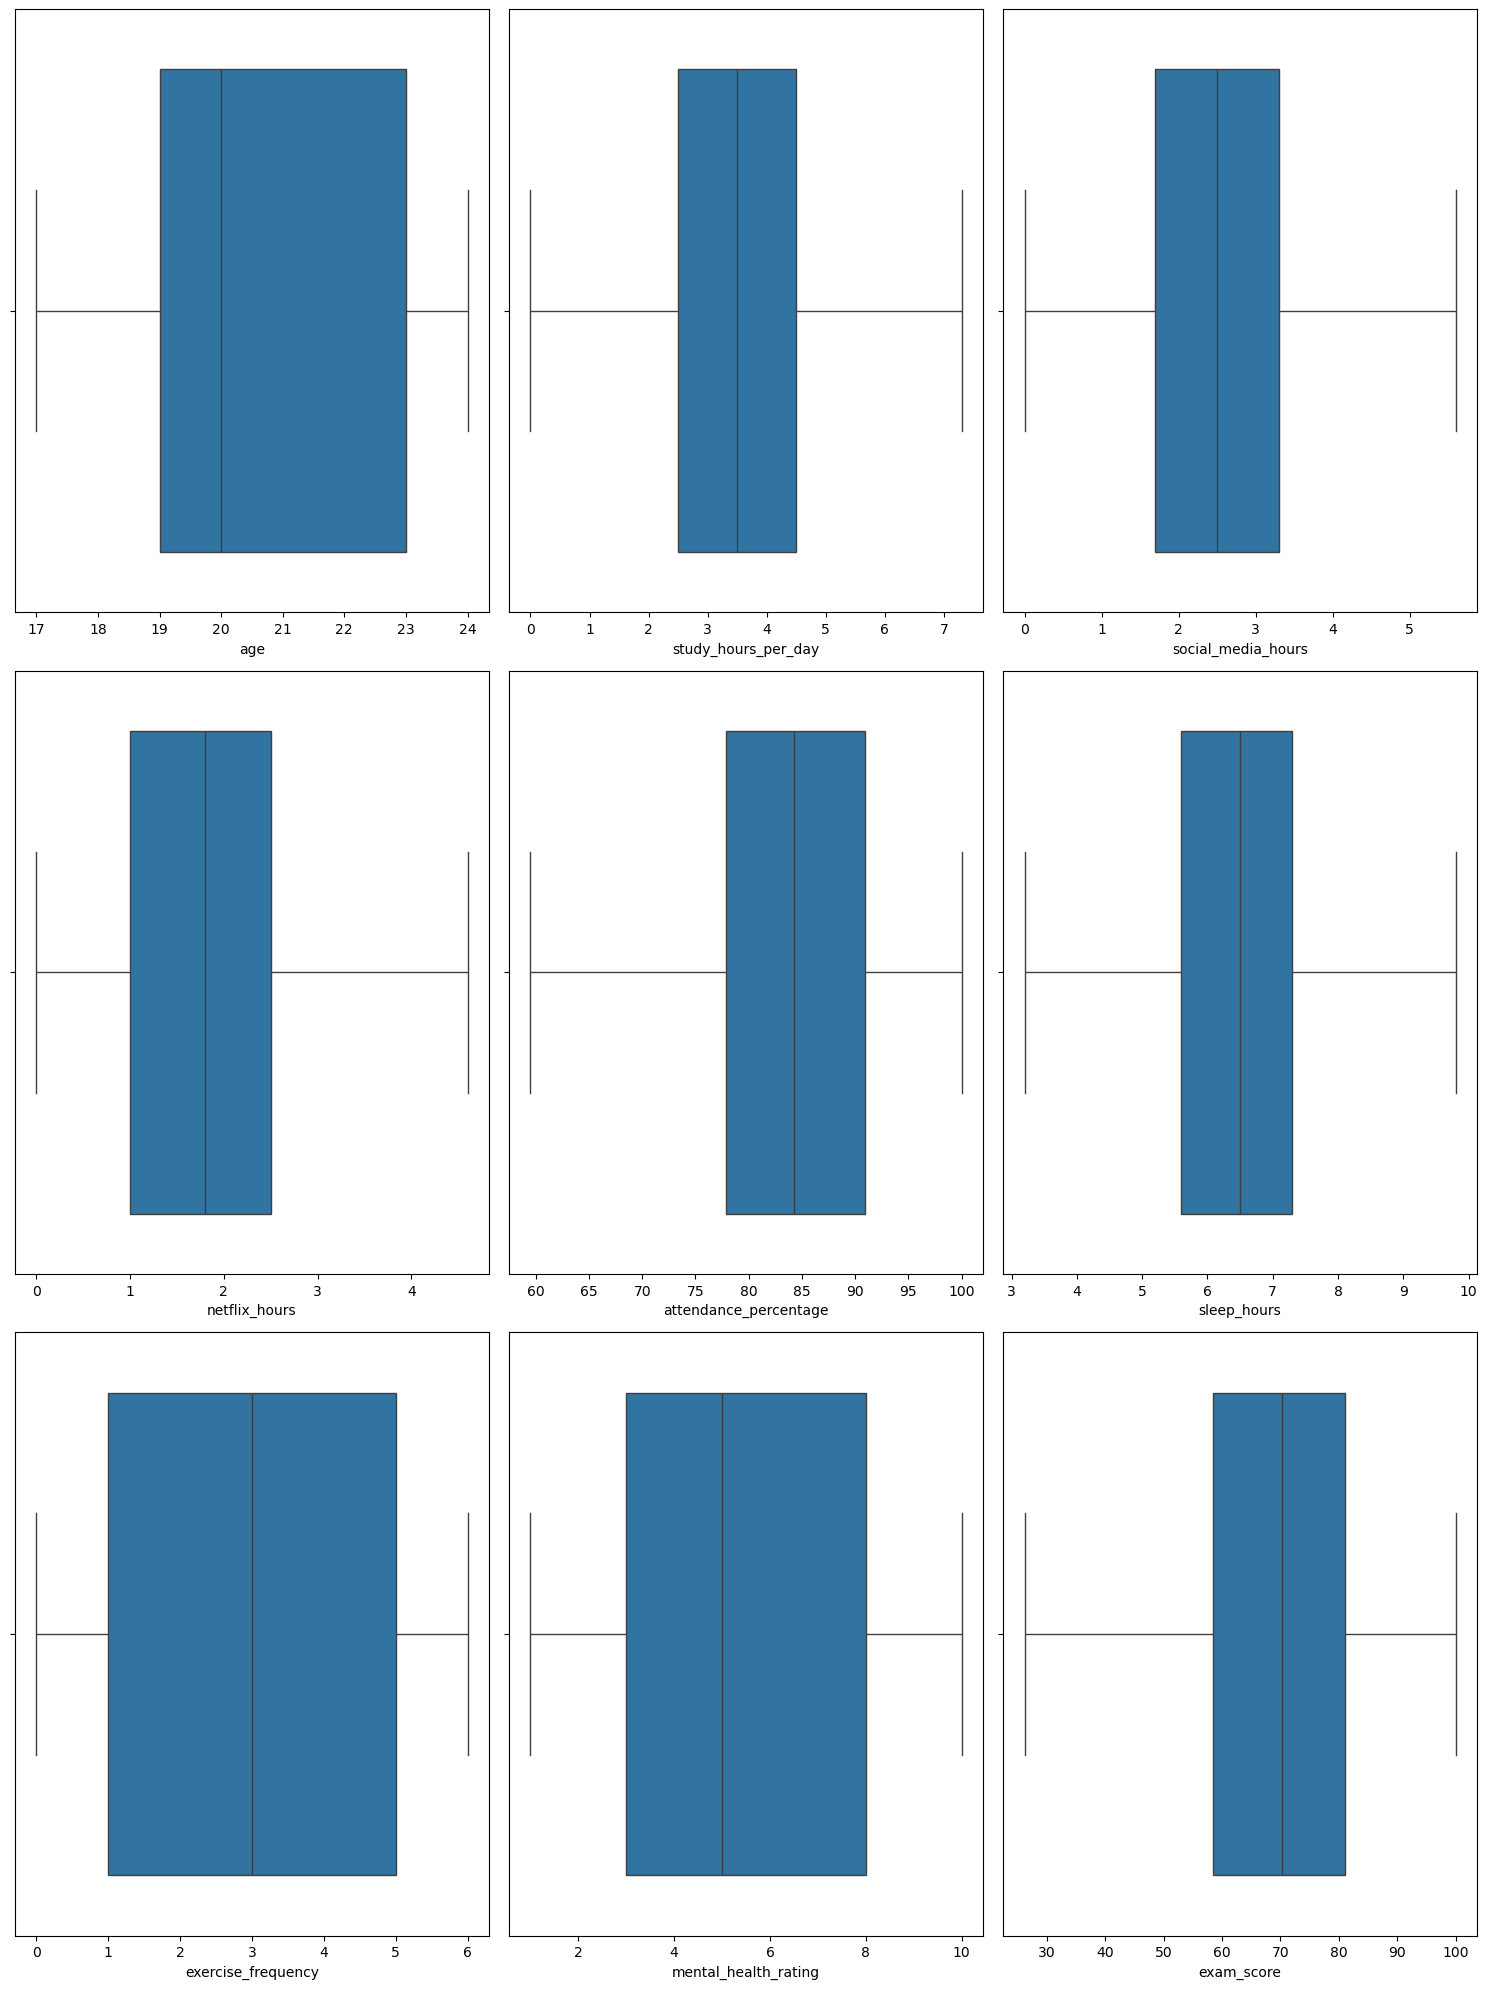

In [28]:
numerical_cols_processed = df_processed.select_dtypes(include='number')
f,axes = plt.subplots(3,3,figsize=(15, 20))

axes = axes.flatten()

for i, feature in enumerate(numerical_cols_processed.columns):
    sns.boxplot(x=df_processed[feature], ax=axes[i])

plt.tight_layout()
plt.savefig('../doc/img/boxplot2.png')
plt.show()